In [4]:
import pandas as pd
import folium
import json
import geopandas as gpd
import plotly.express as px
import matplotlib.pyplot as plt

In [5]:
# !pip install xlrd
# !pip install folium geopandas

# 미국 주 당 천연가스 매장량

In [4]:
df = pd.read_excel('지역별매장량.xls', sheet_name= 'Data 1', header = 2)

print(df.columns)
time_column = 'Date'
df[time_column] = pd.to_datetime(df[time_column])  # 시간 열을 datetime 형식으로 변환
df_date = df.set_index(time_column)  # 여기서 에러가 발생하지 않도록 문자열로 전달

df_date = df_date.loc['2023-06-30']

# 딕셔너리로 변환
df = pd.DataFrame(list(df_date.items()), columns=["State", "Storage Capacity"])

# 'State' 컬럼에서 주 이름만 추출 (첫 번째 항목만 특별 처리)
df['State'] = df['State'].apply(lambda x: "U.S. Total" if "U.S. Total" in x else x.split()[0])


Index(['Date', 'U.S. Total Natural Gas Underground Storage Capacity (MMcf)',
       'Alaska Natural Gas Underground Storage Capacity (MMcf)',
       'Alabama Natural Gas Underground Storage Capacity (MMcf)',
       'Arkansas Natural Gas Underground Storage Capacity (MMcf)',
       'California Natural Gas Underground Storage Capacity (MMcf)',
       'Colorado Natural Gas Underground Storage Capacity (MMcf)',
       'Illinois Natural Gas Underground Storage Capacity (MMcf)',
       'Indiana Natural Gas Underground Storage Capacity (MMcf)',
       'Iowa Natural Gas Underground Storage Capacity (MMcf)',
       'Kansas Natural Gas Underground Storage Capacity (MMcf)',
       'Kentucky Natural Gas Underground Storage Capacity (MMcf)',
       'Louisiana Natural Gas Underground Storage Capacity (MMcf)',
       'Maryland Natural Gas Underground Storage Capacity (MMcf)',
       'Michigan Natural Gas Underground Storage Capacity (MMcf)',
       'Minnesota Natural Gas Underground Storage Capacity 

In [5]:
# GeoJSON 파일 읽기
geojson_file = "map.geojson"
with open(geojson_file, 'r') as f:
    geo_data = json.load(f)

# GeoJSON 파일에 데이터 추가 (State 이름을 기준으로)
for feature in geo_data["features"]:
    state_name = feature["properties"]["name"]
    if state_name in df["State"].values:
        # Storage Capacity 값을 GeoJSON의 속성에 추가
        feature["properties"]["storage_capacity"] = df[df["State"] == state_name]["Storage Capacity"].values[0]

# GeoJSON 파일에 저장된 데이터 확인
# GeoJSON 데이터의 첫 번째 항목을 출력하여 저장된 값을 확인
print(geo_data["features"][0]["properties"])

# 맵 생성
m = folium.Map(location=[37.0902, -95.7129], zoom_start=4)

# Choropleth 맵 추가
folium.Choropleth(
    geo_data=geo_data,
    name="choropleth",
    data=[(f["properties"]["name"], f["properties"].get("storage_capacity", 0)) for f in geo_data["features"]],
    columns=["name", "storage_capacity"],
    key_on="feature.properties.name",
    fill_color="YlOrRd",  # 색상 스케일 (Yellow-Orange-Red)
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name="Storage Capacity"
).add_to(m)

# 맵 표시
m

{'name': 'Alabama', 'density': 94.65, 'storage_capacity': 43600.0}


# 미국 주별 생산

In [17]:
df_P = pd.read_excel('NG_PROD_SUM_A_EPG0_FPD_MMCF_A.xls', sheet_name= 'Data 1', header = 2)

print(df.columns)
time_column = 'Date'
df[time_column] = pd.to_datetime(df[time_column])  # 시간 열을 datetime 형식으로 변환
df_date = df.set_index(time_column)  # 여기서 에러가 발생하지 않도록 문자열로 전달

df_date = df_date.loc['2023-06-30']

# 딕셔너리로 변환
df = pd.DataFrame(list(df_date.items()), columns=["State", "Storage Capacity"])

# 'State' 컬럼에서 주 이름만 추출 (첫 번째 항목만 특별 처리)
df['State'] = df['State'].apply(lambda x: "U.S. Total" if "U.S. Total" in x else x.split()[0])


Index(['Date', 'U.S. Dry Natural Gas Production (MMcf)',
       'Alaska Dry Natural Gas Production (Million Cubic Feet)',
       'Alaska--Onshore Natural Gas Dry Production (Million Cubic Feet)',
       'Alaska--State Offshore Natural Gas Dry Production (Million Cubic Feet)',
       'Arkansas Dry Natural Gas Production (Million Cubic Feet)',
       'California Dry Natural Gas Production (Million Cubic Feet)',
       'Calif--Onshore Natural Gas Dry Production (Million Cubic Feet)',
       'California--State Offshore Natural Gas Dry Production (Million Cubic Feet)',
       'Colorado Dry Natural Gas Production (Million Cubic Feet)',
       'Federal Offshore--Gulf of America Dry Natural Gas Production  (Million Cubic Feet)',
       'Kansas Dry Natural Gas Production (Million Cubic Feet)',
       'Louisiana Dry Natural Gas Production (Million Cubic Feet)',
       'Louisiana--Onshore Natural Gas Dry Production (Million Cubic Feet)',
       'Louisiana--State Offshore Natural Gas Dry Productio

In [19]:
# GeoJSON 파일 읽기
geojson_file = "map.geojson"
with open(geojson_file, 'r') as f:
    geo_data = json.load(f)

# GeoJSON 파일에 데이터 추가 (State 이름을 기준으로)
for feature in geo_data["features"]:
    state_name = feature["properties"]["name"]
    if state_name in df["State"].values:
        # Storage Capacity 값을 GeoJSON의 속성에 추가
        feature["properties"]["storage_capacity"] = df[df["State"] == state_name]["Storage Capacity"].values[0]

# GeoJSON 파일에 저장된 데이터 확인
# GeoJSON 데이터의 첫 번째 항목을 출력하여 저장된 값을 확인
print(geo_data["features"][0]["properties"])

# 맵 생성
m = folium.Map(location=[37.0902, -95.7129], zoom_start=4)

# Choropleth 맵 추가
folium.Choropleth(
    geo_data=geo_data,
    name="choropleth",
    data=[(f["properties"]["name"], f["properties"].get("storage_capacity", 0)) for f in geo_data["features"]],
    columns=["name", "storage_capacity"],
    key_on="feature.properties.name",
    fill_color="YlOrRd",  # 색상 스케일 (Yellow-Orange-Red)
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name="Storage Capacity"
).add_to(m)

# 맵 표시
m

{'name': 'Alabama', 'density': 94.65}


# 텍사스 주 우물정보(개수, 깊이)

In [6]:
df_01 = pd.read_excel('텍사스주_우물정보_25_02.xls', sheet_name= '01')
df_02 = pd.read_excel('텍사스주_우물정보_25_02.xls', sheet_name= '02')
df_03 = pd.read_excel('텍사스주_우물정보_25_02.xls', sheet_name= '03')
df_04 = pd.read_excel('텍사스주_우물정보_25_02.xls', sheet_name= '04')
df_05 = pd.read_excel('텍사스주_우물정보_25_02.xls', sheet_name= '05')
df_06 = pd.read_excel('텍사스주_우물정보_25_02.xls', sheet_name= '06')
df_08 = pd.read_excel('텍사스주_우물정보_25_02.xls', sheet_name= '08')
df_09 = pd.read_excel('텍사스주_우물정보_25_02.xls', sheet_name= '09')
df_10 = pd.read_excel('텍사스주_우물정보_25_02.xls', sheet_name= '10')
df_11 = pd.read_excel('텍사스주_우물정보_25_02.xls', sheet_name= '7B')
df_12 = pd.read_excel('텍사스주_우물정보_25_02.xls', sheet_name= '7C')
df_13 = pd.read_excel('텍사스주_우물정보_25_02.xls', sheet_name= '8A')

# Combine all the dataframes into one
df = pd.concat([df_01, df_02, df_03, df_04, df_05, df_06, df_08, df_09, df_10, df_11, df_12, df_13], ignore_index=True)

# 데이터 열 고르기
selected_columns = df[['API Number', 'County Name', 'County Number', 'Bottom Total Depth']]

# county 값 갯수 카운트
selected_columns['County Name'].value_counts()

# county 기준으로 내림차순 정렬
sorted_selected_columns = selected_columns.sort_values(by=['County Name', 'Bottom Total Depth'], ascending=[True, False])
sorted_selected_columns.head()

# county 마다 평균 깊이
county_avg_depth = sorted_selected_columns.groupby('County Name')['Bottom Total Depth'].mean()

# county 별 갯수와 평균 깊이를 계산(최종 데이터 프레임)
county_stats = sorted_selected_columns.groupby(['County Name', 'County Number']).agg(
    County_Count=('County Name', 'size'),
    County_Avg_Depth=('Bottom Total Depth', 'mean')
).reset_index()

county_c_a = county_stats[['County Name', 'County_Count', 'County_Avg_Depth']]

county_c_a.loc[county_c_a['County Name'] == 'SAN AUGUSTINE', 'County_Avg_Depth'] = 21420

county_c_a['County Name'] = county_c_a['County Name'].str.upper()

texas_counties = gpd.read_file('tx_counties.geojson')  

# 3. 중심점 계산
texas_counties['centroid'] = texas_counties.geometry.centroid
texas_counties['lat'] = texas_counties['centroid'].y
texas_counties['lon'] = texas_counties['centroid'].x

# 4. GeoJSON의 COUNTY 이름 조정
# "Sherman County" -> "SHERMAN"으로 변환 (대문자)
texas_counties['COUNTY'] = texas_counties['COUNTY'].str.replace(' County', '').str.upper()

# 병합
map_data = texas_counties.merge(county_c_a, how='left', left_on='COUNTY', right_on='County Name')

# 5. NaN 값 처리
map_data['County_Count'] = map_data['County_Count'].fillna(0)
map_data['County_Avg_Depth'] = map_data['County_Avg_Depth'].fillna(0)


C:\Users\qkrgu\AppData\Local\Temp\ipykernel_18084\2399631983.py:40: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\qkrgu\AppData\Local\Temp\ipykernel_18084\2399631983.py:45: UserWarning:

Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.




In [7]:
# county 별 분지
basin_data = pd.read_excel('생산분지.xlsx', sheet_name= 'RegionCounties')

# 카운티랑 생산분지만 뽑음
filtered_basin_data = basin_data[basin_data['State'] == 'TX'][['County', 'Region']]

texas_counties = gpd.read_file('tx_counties.geojson')  # 실제 경로로 대체

# 3. 중심점 계산
texas_counties['centroid'] = texas_counties.geometry.centroid
texas_counties['lat'] = texas_counties['centroid'].y
texas_counties['lon'] = texas_counties['centroid'].x

# 4. GeoJSON의 COUNTY 이름 조정 (대문자)
texas_counties['COUNTY'] = texas_counties['COUNTY'].str.replace(' County', '').str.upper()

# 5. county_c_a와 GeoJSON 병합 (geometry 유지)
map_data = texas_counties.merge(county_c_a, how='left', left_on='COUNTY', right_on='County Name')

# 6. filtered_basin_data 병합
# 예: filtered_basin_data = pd.DataFrame({'County': ['HARRIS', 'BEXAR'], 'Region': ['Gulf Coast', 'Permian']})
map_data = map_data.merge(filtered_basin_data, how='left', left_on='County Name', right_on='County')

# 7. NaN 값 처리
map_data['County_Count'] = map_data['County_Count'].fillna(0)
map_data['County_Avg_Depth'] = map_data['County_Avg_Depth'].fillna(0)
map_data['Region'] = map_data['Region'].fillna('Unknown')

C:\Users\qkrgu\AppData\Local\Temp\ipykernel_18084\3701101259.py:10: UserWarning:

Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.




In [9]:
import plotly.graph_objects as go

# 8. 깊이 정규화 (0~1 사이로 색상 강도에 사용)
depth_min = map_data['County_Avg_Depth'].min()
depth_max = map_data['County_Avg_Depth'].max()
if depth_max > depth_min:
    map_data['depth_normalized'] = (map_data['County_Avg_Depth'] - depth_min) / (depth_max - depth_min)
else:
    map_data['depth_normalized'] = 1.0

# 10. 버블 지도 그리기
fig = go.Figure()

# Region별 색상 팔레트 
region_colors = {
    'Eagle Ford Region': ['#1f77b4', '#08306b'],  # 파랑 계열 (밝음 → 어두움)
    'Anadarko Region': ['#ff7f0e', '#7f3b08'],   # 주황 계열
    'Haynesville Region': ['#2ca02c', '#0c4011'], # 초록 계열
    'Permian Region': ['#d62728', '#67000d'],     # 빨강 계열
    'Unknown': ['#7f7f7f', '#3f3f3f']            # 회색 계열
}

# 각 Region별로 데이터 분리 후 플롯
for region, (light_color, dark_color) in region_colors.items():
    region_data = map_data[map_data['Region'] == region]
    if not region_data.empty:
        # 깊이에 따라 색상 보간
        colors = [light_color if d < 0.5 else dark_color for d in region_data['depth_normalized']]
        fig.add_trace(
            go.Scattergeo(
                lat=region_data['lat'],
                lon=region_data['lon'],
                text=region_data['County Name'] + '<br>Count: ' + region_data['County_Count'].astype(str) + '<br>Depth: ' + region_data['County_Avg_Depth'].astype(str),
                mode='markers',
                marker=dict(
                    size=region_data['County_Count'],
                    sizemode='area',
                    sizeref=2. * max(map_data['County_Count']) / (70.**2),  # 원래 크기 유지
                    sizemin=8,
                    color=colors,  # 깊이에 따른 색상 변화
                    line=dict(width=0.5, color='black')
                ),
                name=region
            )
        )

# 지도 레이아웃 설정
fig.update_geos(
    scope='usa',
    lataxis_range=[25, 37],
    lonaxis_range=[-107, -93],
    center={'lat': 31.0, 'lon': -100.0}
)
fig.update_layout(
    title='Texas Counties: Well Density (Size), Production Basin & Depth (Color)',
    margin={"r":0, "t":50, "l":0, "b":0},
    legend_title_text='Production Basin'
)

fig.show()

# 생산분지에 따른 시간흐름에 관한 생상량

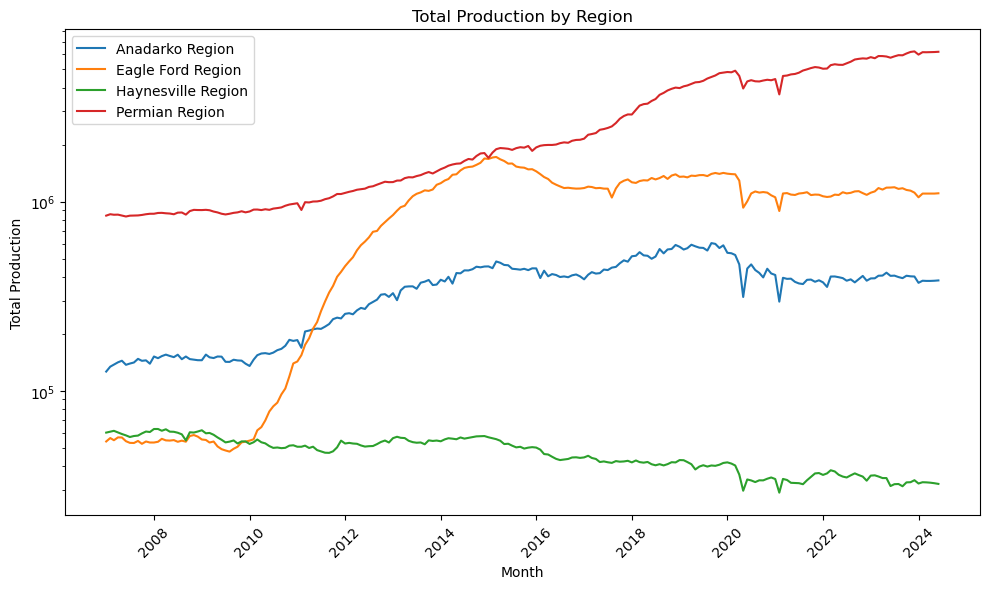

In [27]:
# 특정 시트만 로드 (2번째 행을 컬럼명으로 설정)
sheets = ["Anadarko Region", "Eagle Ford Region", "Haynesville Region", "Permian Region"]
df_dict = pd.read_excel('생산분지.xlsx', sheet_name=sheets, header=1)  # header=1로 설정

# 각 시트에 'Region' 컬럼 추가
for region in df_dict:
    df_dict[region]['Region'] = region  # 시트 이름을 'Region' 컬럼에 추가

# 모든 시트를 하나의 데이터프레임으로 합치기
df = pd.concat(df_dict.values(), ignore_index=True)

# 'Month', 'Total production', 'Region' 컬럼만 선택
df_mon_pro = df[['Month', 'Total production', 'Region']]

# 'Month'를 datetime 형식으로 변환 (필요 시)
df_mon_pro.loc[:, 'Month'] = pd.to_datetime(df_mon_pro['Month'], format='%Y-%m')

# 그래프 그리기
plt.figure(figsize=(10, 6))

# 각 지역에 대해 선 그래프 그리기
for region in df_mon_pro['Region'].unique():
    region_data = df_mon_pro[df_mon_pro['Region'] == region]
    plt.plot(region_data['Month'], region_data['Total production'], label=region)

# 그래프 제목 및 축 레이블 설정
plt.title('Total Production by Region')
plt.xlabel('Month')
plt.ylabel('Total Production')

# y축을 로그 스케일로 설정 (선택 사항)
plt.yscale('log')

# 범례 추가
plt.legend()

# 그래프 표시
plt.xticks(rotation=45)  # x축 날짜 라벨 회전
plt.tight_layout()  # 레이아웃 조정
plt.show()


# 시간에 따른 천연가스 가격 변동

In [1]:

import pandas as pd
import plotly.express as px

df = pd.read_excel('RNGWHHDm.xls', sheet_name= 'Data 1', header = 2)

print(df.columns)
time_column = 'Date'
df[time_column] = pd.to_datetime(df[time_column])  # 시간 열을 datetime 형식으로 변환
df_date = df.set_index(time_column) 

# 1. 네 데이터프레임 (가정: gas_prices라는 이름)
# 네 실제 데이터프레임 이름으로 대체
df = df.copy()

# 2. 열 이름 간소화
df = df.rename(columns={'Henry Hub Natural Gas Spot Price (Dollars per Million Btu)': 'Price'})

# 3. 날짜를 datetime으로 변환
df['Date'] = pd.to_datetime(df['Date'])

# 4. 2007년 이후 데이터 필터링
df = df[df['Date'] >= '2007-01-01']

# 5. 날짜를 연도 단위로 그룹화
df['Year'] = df['Date'].dt.year

# 6. 박스 그래프 생성
fig = px.box(
    df,
    x='Year',
    y='Price',
    title='Henry Hub Natural Gas Prices by Year (2007 onwards)',
    labels={'Year': 'Year', 'Price': 'Price (USD/MMBtu)'},
    color='Year',  # 연도별 색상 구분
    points='all'  # 개별 데이터 포인트 표시
)

# 7. 레이아웃 조정
fig.update_layout(
    xaxis_title='Year',
    yaxis_title='Price (USD/MMBtu)',
    showlegend=False,  # 범례 제거
    xaxis={'tickangle': 45}  # x축 레이블 45도 회전
)

fig.show()

Index(['Date', 'Henry Hub Natural Gas Spot Price (Dollars per Million Btu)'], dtype='object')
